# See if Scoary predicted resistant genes cluster together

In [1]:
import pandas as pd

def read_scoary(abx):
    fname = '~/data0118/scoary/{}_12_09_2019_0534.results.csv'.format(abx)
    df = pd.read_csv(fname, header = 0, index_col = 0)
    return(df)
def odds_ratio(df, fc_thres = 8, p_thres= 0.01):
    '''
    filter df with pvalue
    input scoary output df, output resistant determinant/susceptibility determinants
    '''
    # filter for p value
    d = df.loc[df['Bonferroni_p']<p_thres]
    
    return df.loc[df['Odds_ratio']> fc_thres].index, df.loc[df['Odds_ratio']< fc_thres].index

In [2]:
from glob import glob
abx_list = [x.split('/')[-1].split('_')[0] for x in glob('/home/hermuba/data0118/scoary/*.results.csv')]

In [3]:
gold_anno = pd.read_pickle('~/data0118/goldstandard/ec_rmplasmid_node_anno_df')

In [4]:
resist = pd.DataFrame(index = abx_list, columns = gold_anno['cluster'])
suscept = pd.DataFrame(index = abx_list, columns = gold_anno['cluster'])

for a in abx_list:
    df = read_scoary(a) # read scoary table for antibiotics
    r,s = odds_ratio(df) # resistant (r), subceptible(s)
    resist.loc[a, r] = 1 # if as resistant
    suscept.loc[a, s] = 1 # is as subceptible
resist = resist.loc[:,resist.count()>1].fillna(0)
suscept = suscept.loc[:,suscept.count()>1].fillna(0)

In [5]:
resist.head()

cluster,Cluster 11267,Cluster 21370,Cluster 30220,Cluster 22150,Cluster 2710,Cluster 25640,Cluster 19104,Cluster 20333,Cluster 26403,Cluster 17073,...,Cluster 27943,Cluster 3510,Cluster 19943,Cluster 5686,Cluster 17920,Cluster 18729,Cluster 30331,Cluster 29515,Cluster 13557,Cluster 8839
cefoxitin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
gentamicin,0,1,0,0,1,1,0,1,1,1,...,0,1,1,1,1,0,1,1,0,0
cefotaxime,0,0,0,0,1,0,0,0,0,0,...,1,1,0,1,1,0,1,1,1,1
cefuroxime,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cefepime,1,1,1,1,1,1,0,1,1,1,...,0,0,0,0,0,1,0,1,0,1


In [6]:
# import known prior knowledge
from candidate_gene import *
card_abx, card_efflux = card()
resfam_mech, resfam_abx = resfam()
drug_df = drug()
drug_legend = drug_legend(drug_df)

/home/hermuba/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


/home/hermuba/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


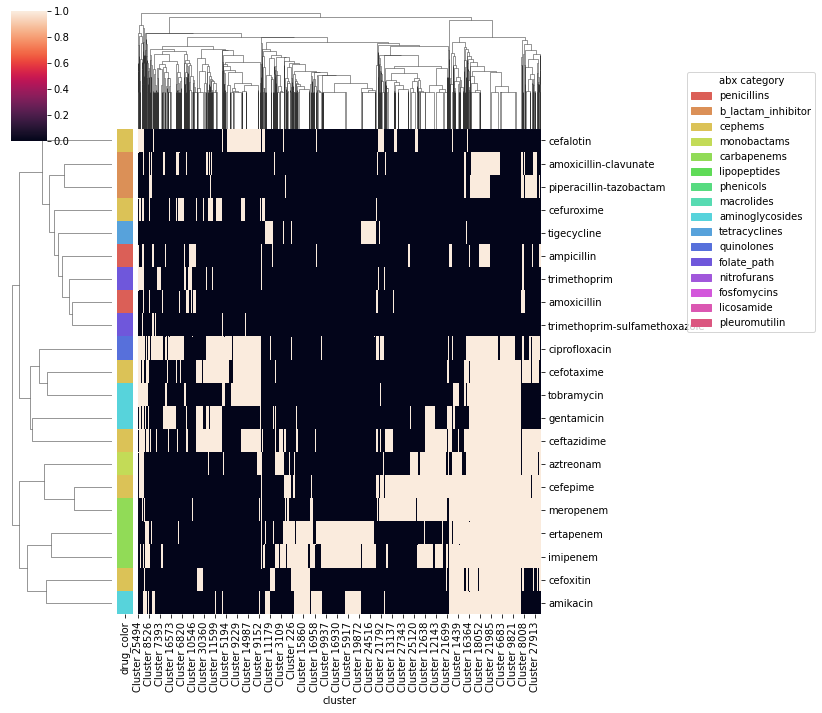

In [7]:
%matplotlib inline
import seaborn as sns
g = sns.clustermap(resist, row_colors = drug_df.loc[resist.index, 'drug_color'])
l=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.35,0.85),handles=drug_legend,frameon=True)
l.set_title(title='abx category',prop={'size':10})

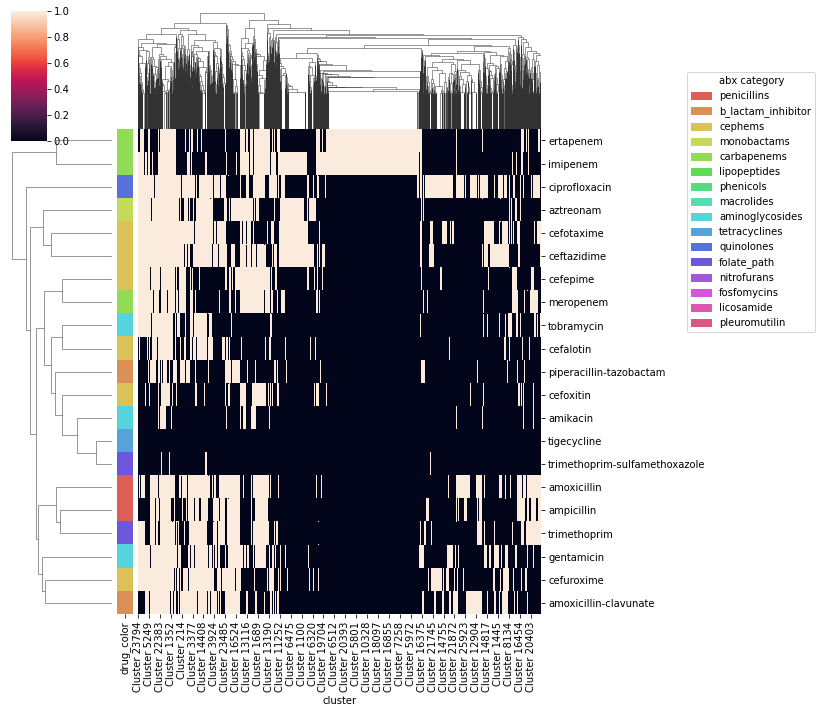

In [8]:
g = sns.clustermap(suscept, row_colors = drug_df.loc[suscept.index, 'drug_color'])
l=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.35,0.85),handles=drug_legend,frameon=True)
l.set_title(title='abx category',prop={'size':10})

In [9]:
# see if a gene can be protective for one and demaging for another drug
combine = pd.DataFrame(index = abx_list, columns = gold_anno['cluster'])
for a in abx_list:
    df = read_scoary(a)
    r,s = odds_ratio(df)
    combine.loc[a, r] = 1
    combine.loc[a, s] = -1
combine = combine.loc[:, combine.count()>1].fillna(0)

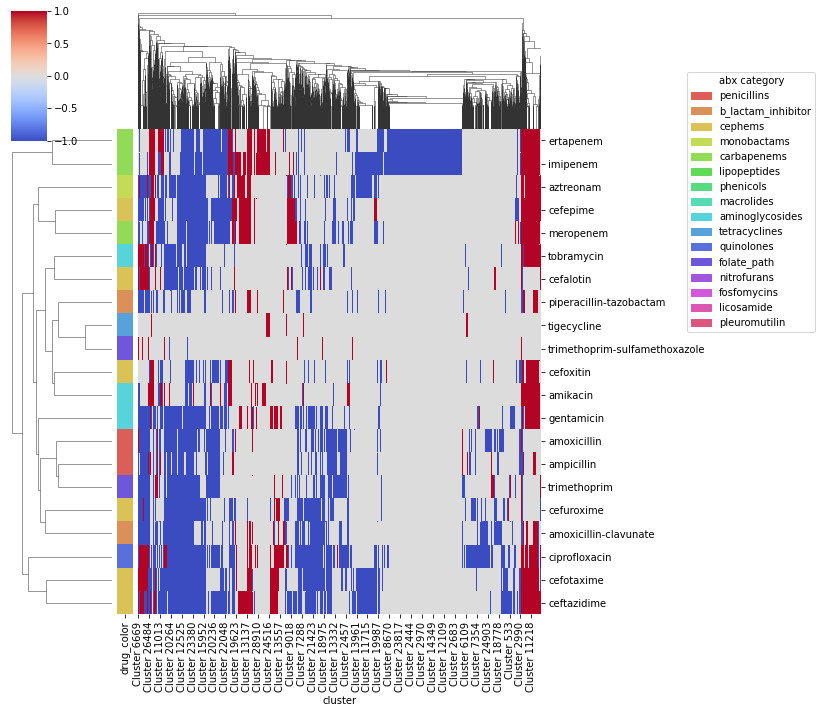

In [10]:
g = sns.clustermap(combine, cmap = 'coolwarm', row_colors = drug_df.loc[combine.index, 'drug_color'])
l=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.35,0.85),handles=drug_legend,frameon=True)
l.set_title(title='abx category',prop={'size':10})

In [11]:
import numpy as np
combine_value = pd.DataFrame(index = abx_list, columns = gold_anno['cluster'])
for a in abx_list:
    df = read_scoary(a)
    
    combine_value.loc[a, df.index] = df['Odds_ratio']
combine_value = combine_value.loc[:, combine_value.count()>1].replace(np.inf, 1000).replace(-np.inf,0.001).replace(0,1).fillna(1)

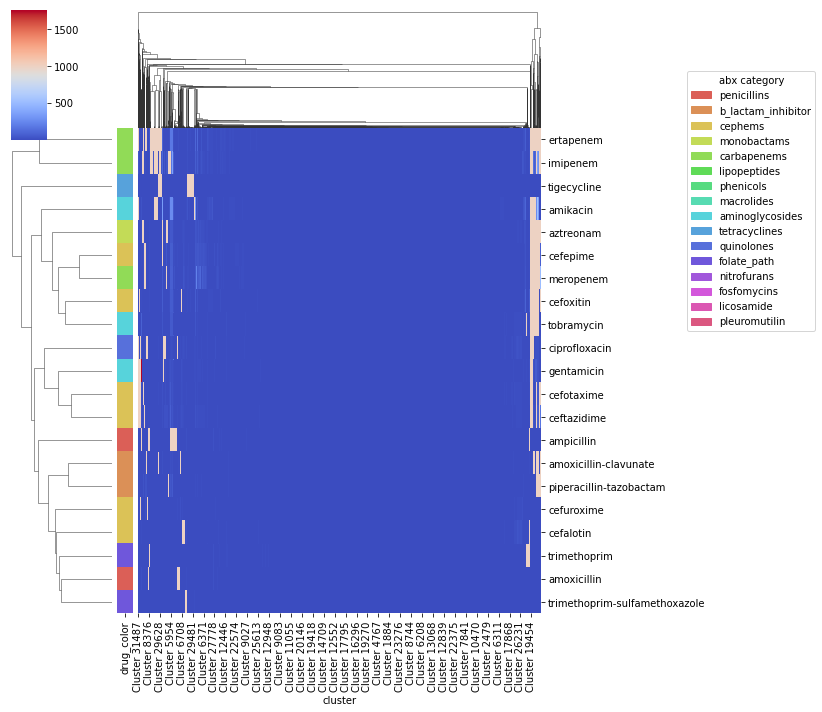

In [12]:
g = sns.clustermap(combine_value, cmap = 'coolwarm', row_colors = drug_df.loc[combine_value.index, 'drug_color'])
l=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.35,0.85),handles=drug_legend,frameon=True)
l.set_title(title='abx category',prop={'size':10})

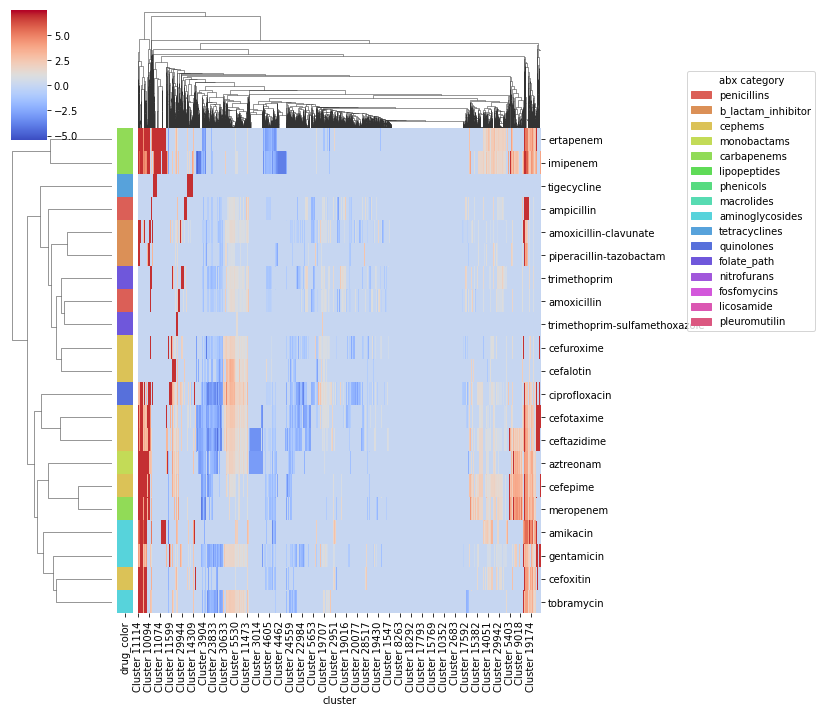

In [13]:
import math
g = sns.clustermap(np.log(combine_value), cmap = 'coolwarm',row_colors = drug_df.loc[combine_value.index, 'drug_color'])
l=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.35,0.85),handles=drug_legend,frameon=True)
l.set_title(title='abx category',prop={'size':10})

In [19]:
sum_stat = pd.DataFrame(index = abx_list, columns = ['card_count', 'resfam_count', 'hypo_count', 'total_genes'])
for abx in abx_list:
    df = read_scoary(abx)
    sum_stat.loc[abx, ['card_count','hypo_count']] = gold_anno.loc[gold_anno['cluster'].isin(df.index), ['is_card', 'hypo_nr']].sum().values
    sum_stat.loc[abx, 'resfam_count'] = gold_anno.loc[gold_anno['cluster'].isin(df.index), 'resfam'].count()
    sum_stat.loc[abx, 'total_genes'] = df.shape[0]
    

TypeError: only list-like objects are allowed to be passed to isin(), you passed a [builtin_function_or_method]

In [15]:
sum_stat

,card_count,resfam_count,hypo_count,total_genes
cefoxitin,15,84,846,1998
gentamicin,35,161,1786,4028
cefotaxime,30,200,2137,4948
cefuroxime,19,122,1533,3417
cefepime,31,158,1666,3696
ampicillin,25,125,1011,2659
amoxicillin,26,169,1490,3700
tobramycin,17,92,1100,2452
cefalotin,12,76,760,1906
ceftazidime,36,248,2360,5560


In [16]:
def compare_annotation(anno, gold_anno):
    sum_curation = pd.DataFrame(index = abx_list, columns = anno.unique())
    for abx in abx_list:
        df = read_scoary(abx)
        genes = gold_anno.loc[gold_anno['cluster'].isin(df.index)].index
        sum_curation.loc[abx] = anno.loc[list(set(genes).intersection(set(anno.index)))].value_counts()
    return(sum_curation)
    
        

# Compare annotation CARD/resfam with the scoary significant genes
- gene with annotations are extracted
- normalize per antibiotic

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

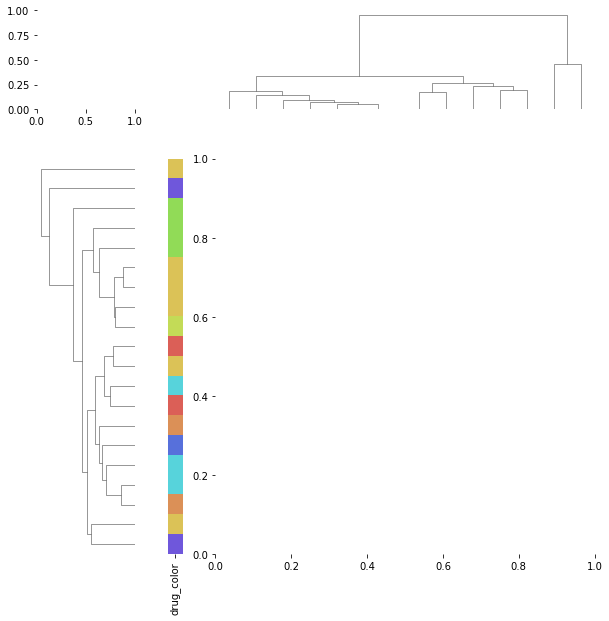

In [17]:
s = compare_annotation(card_abx, gold_anno)
s = s.loc[s.sum(axis = 1)> 1]
s = s.div(s.sum(axis = 1), axis = 0)
g = sns.clustermap(s, cmap = 'coolwarm', annot = True,row_colors = drug_df.loc[combine_value.index, 'drug_color'])
l=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.35,0.85),handles=drug_legend,frameon=True)
l.set_title(title='abx category',prop={'size':10})

In [ ]:
s = compare_annotation(card_efflux, gold_anno)
sns.clustermap(s.fillna(0), cmap = 'coolwarm', annot = True)

In [ ]:
s = compare_annotation(resfam_abx, gold_anno)
s = s.loc[s.sum(axis = 1)> 1]
s = s.div(s.sum(axis = 1), axis = 0)
g = sns.clustermap(s, cmap = 'coolwarm', annot = True,row_colors = drug_df.loc[combine_value.index, 'drug_color'])
l=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.35,0.85),handles=drug_legend,frameon=True)
l.set_title(title='abx category',prop={'size':10})

In [ ]:
s = compare_annotation(resfam_mech, gold_anno)
s = s.loc[s.sum(axis = 1)> 1]
s = s.div(s.sum(axis = 1), axis = 0)
g = sns.clustermap(s, cmap = 'coolwarm', annot = True,row_colors = drug_df.loc[combine_value.index, 'drug_color'])
l=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.35,0.85),handles=drug_legend,frameon=True)
l.set_title(title='abx category',prop={'size':10})
# seems to be the pumps that mess up things

In [ ]:
# remove the efflux pumps to see
s = compare_annotation(resfam_mech, gold_anno)
s = s.drop(columns = ['RND Antibiotic Efflux', 'Other Efflux', 'MFS Transporter', 'ABC Transporter', 'Gene Modulating Resistance'])
s = s.loc[s.sum(axis = 1)> 1]
s = s.div(s.sum(axis = 1), axis = 0)
g = sns.clustermap(s, cmap = 'coolwarm', annot = True,row_colors = drug_df.loc[combine_value.index, 'drug_color'])
l=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.35,0.85),handles=drug_legend,frameon=True)
l.set_title(title='abx category',prop={'size':10})


In [ ]:
cog = pd.read_csv('~/data0118/goldstandard/cog_df.csv', header = 0, index_col = 0)
sum_cog = pd.DataFrame(index = abx_list, columns = cog.columns)
for abx in abx_list:
    df = read_scoary(abx)
    genes = gold_anno.loc[gold_anno['cluster'].isin(df.index)].index
    sum_cog.loc[abx] = cog.loc[genes].sum()
        

In [ ]:
cog_anno = pd.read_csv('~/bin/COGmapper/COGcategory.txt', sep = '\t', header = None, names = ['COG', 'description'])
cog_anno['joined_str'] = cog_anno[['COG', 'description']].apply(lambda x: ': '.join(x), axis=1)
cog_anno.set_index('COG', inplace = True)

In [ ]:
g = sns.clustermap(sum_cog.iloc[:, :-1].rename(columns = cog_anno['joined_str']), standard_scale = 0, annot = True, figsize = (15,15),row_colors = drug_df.loc[combine_value.index, 'drug_color'])
l=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.35,0.85),handles=drug_legend,frameon=True)
l.set_title(title='abx category',prop={'size':10})


In [ ]:
# if we only look at the resistant determinats (odds ratio > 1)
def compare_annotation_split(anno, gold_anno, goal):
    sum_curation = pd.DataFrame(index = abx_list, columns = anno.unique())
    for abx in abx_list:
        df = read_scoary(abx)
        if goal =='resist':
            df = df.loc[df['Odds_ratio']> 1]
        else:
            df = df.loc[df['Odds_ratio']< 1]
        genes = gold_anno.loc[gold_anno['cluster'].isin(df.index)].index
        sum_curation.loc[abx] = anno.loc[list(set(genes).intersection(set(anno.index)))].value_counts()
        
        # normalize
        #sum_curation = sum_curation.div(sum_curation.sum(axis=1), axis=0)
    return(sum_curation)

In [ ]:
s = compare_annotation_split(card_abx, gold_anno, 'resist')
s = s.loc[s.sum(axis = 1)> 1]
s = s.div(s.sum(axis = 1), axis = 0)
g = sns.clustermap(s, cmap = 'coolwarm', annot = True,row_colors = drug_df.loc[combine_value.index, 'drug_color'])
l=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.35,0.85),handles=drug_legend,frameon=True)
l.set_title(title='abx category',prop={'size':10})

In [ ]:
s = compare_annotation_split(card_abx, gold_anno, 'suscept')
s = s.loc[s.sum(axis = 1)> 1]
s = s.div(s.sum(axis = 1), axis = 0)
g = sns.clustermap(s, cmap = 'coolwarm', annot = True,row_colors = drug_df.loc[combine_value.index, 'drug_color'])
l=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.35,0.85),handles=drug_legend,frameon=True)
l.set_title(title='abx category',prop={'size':10})

In [ ]:
s = compare_annotation_split(card_efflux, gold_anno, 'resist')
sns.clustermap(s.fillna(0), cmap = 'coolwarm', annot = True)

In [ ]:
s = compare_annotation_split(card_efflux, gold_anno, 'suscept')
sns.clustermap(s.fillna(0), cmap = 'coolwarm', annot = True)

In [ ]:
s = compare_annotation_split(resfam_abx, gold_anno, 'resist')
s = s.drop(columns = ['RND Antibiotic Efflux', 'Other Efflux', 'MFS Transporter', 'ABC Transporter', 'Gene Modulating Resistance'])
s = s.loc[s.sum(axis = 1)> 1]
s = s.div(s.sum(axis = 1), axis = 0)
g = sns.clustermap(s, cmap = 'coolwarm', annot = True,row_colors = drug_df.loc[combine_value.index, 'drug_color'])
l=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.35,0.85),handles=drug_legend,frameon=True)
l.set_title(title='abx category',prop={'size':10})

In [ ]:
s = compare_annotation_split(resfam_mech, gold_anno, 'resist')
s = s.loc[s.sum(axis = 1)> 1]
s = s.div(s.sum(axis = 1), axis = 0)
g = sns.clustermap(s, cmap = 'coolwarm', annot = True,row_colors = drug_df.loc[combine_value.index, 'drug_color'])
l=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.35,0.85),handles=drug_legend,frameon=True)
l.set_title(title='abx category',prop={'size':10})

In [ ]:
s = compare_annotation_split(resfam_mech, gold_anno, 'resist')
s = s.drop(columns = ['RND Antibiotic Efflux', 'Other Efflux', 'MFS Transporter', 'ABC Transporter', 'Gene Modulating Resistance'])
s = s.loc[s.sum(axis = 1)> 1]
s = s.div(s.sum(axis = 1), axis = 0)
g = sns.clustermap(s, cmap = 'coolwarm', annot = True,row_colors = drug_df.loc[combine_value.index, 'drug_color'])
l=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.35,0.85),handles=drug_legend,frameon=True)
l.set_title(title='abx category',prop={'size':10})

In [ ]:
s = compare_annotation_split(resfam_mech, gold_anno, 'suscept')
s = s.loc[s.sum(axis = 1)> 1]
s = s.div(s.sum(axis = 1), axis = 0)
g = sns.clustermap(s, cmap = 'coolwarm', annot = True,row_colors = drug_df.loc[combine_value.index, 'drug_color'])
l=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.35,0.85),handles=drug_legend,frameon=True)
l.set_title(title='abx category',prop={'size':10})

In [ ]:
combine_value.head()

In [20]:
resist.to_csv('~/data0118/scoary_summary/resist.csv')
suscept.to_csv('~/data0118/scoary_summary/suscept.csv')
combine.to_csv('~/data0118/scoary_summary/combine.csv')
combine_value.to_csv('~/data0118/scoary_summary/combine_value.csv')
sum_stat.to_csv('~/data0118/scoary_summary/sum_stat.csv')